In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install plotly ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=562be63974e48ac5aea90df756ade200e544c4c7348c51f142fa9b557486aa6b
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import joblib
from datetime import datetime, timedelta

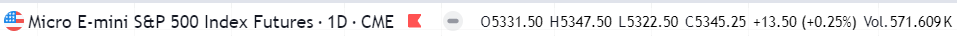

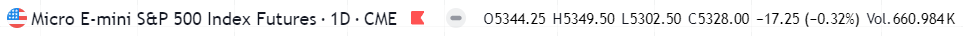

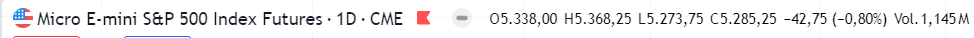

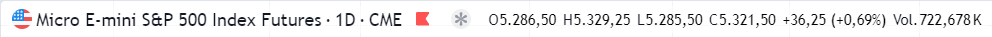

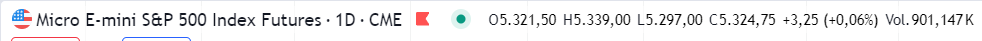

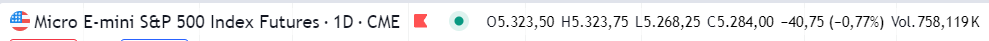

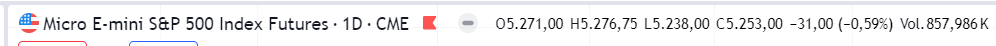

In [ ]:
# Recopilación de Datos
sp500_ticker = "MES=F"
start_date = "2020-05-25"
end_date = "2024-05-31"

sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)
sp500_close_volume = sp500_data[["Open", "High", "Low", 'Close', 'Volume']]
vix_data = yf.download("^VIX", start=start_date, end=end_date)

# Establecer un valor específico para 'Close' y 'Volume' en las dos última fecha
last_index = sp500_close_volume.index[-2]  # Obtiene el último índice
sp500_close_volume.at[last_index, 'Open'] = 5323.50
sp500_close_volume.at[last_index, 'High'] = 5323.75
sp500_close_volume.at[last_index, 'Low'] = 5268.25
sp500_close_volume.at[last_index, 'Close'] = 5284.00
sp500_close_volume.at[last_index, 'Volume'] = 758119

last_index = sp500_close_volume.index[-1]  # Obtiene el último índice
sp500_close_volume.at[last_index, 'Open'] = 5271.00
sp500_close_volume.at[last_index, 'High'] = 5276.75
sp500_close_volume.at[last_index, 'Low'] = 5238.00
sp500_close_volume.at[last_index, 'Close'] = 5253.00
sp500_close_volume.at[last_index, 'Volume'] = 857986

# Ingeniería de Características
#sp500_close_volume['EMA_20'] = ta.trend.EMAIndicator(sp500_close_volume['Close'], window=20).ema_indicator()
sp500_close_volume['SMA_10'] = ta.trend.SMAIndicator(sp500_close_volume['Close'], window=10).sma_indicator()
sp500_close_volume['SMA_5'] = ta.trend.SMAIndicator(sp500_close_volume['Close'], window=5).sma_indicator()
sp500_close_volume['RSI_14'] = ta.momentum.RSIIndicator(sp500_close_volume['Close'], window=14).rsi()
sp500_close_volume['CCI'] = ta.trend.CCIIndicator(sp500_close_volume['High'], sp500_close_volume['Low'], sp500_close_volume['Close'], window=14).cci()
sp500_close_volume['ATR'] = ta.volatility.AverageTrueRange(sp500_close_volume['High'], sp500_close_volume['Low'], sp500_close_volume['Close'], window=14).average_true_range()
sp500_close_volume['VIX'] = vix_data[['Close']]

# Guardar el DataFrame sp500_close_volume como CSV en la ruta especificada
csv_path_sp500 = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240530_entrada_v8.csv'
sp500_close_volume.to_csv(csv_path_sp500, index=True)

sp500_close_volume

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open     High      Low    Close   Volume    SMA_10    SMA_5  \
Date                                                                         
2020-05-26  2948.75  3019.75  2947.75  2994.50  1023998       NaN      NaN   
2020-05-27  2994.25  3039.75  2965.50  3035.50  1168154       NaN      NaN   
2020-05-28  3034.50  3065.50  3019.50  3038.00   958717       NaN      NaN   
2020-05-29  3036.00  3058.50  2992.25  3042.00  1176313       NaN      NaN   
2020-06-01  3032.00  3058.75  3007.75  3054.00   714753       NaN  3032.80   
...             ...      ...      ...      ...      ...       ...      ...   
2024-05-23  5338.00  5368.25  5273.75  5285.25  1145145  5303.200  5323.50   
2024-05-24  5286.50  5329.25  5285.50  5321.50   722678  5310.725  5322.35   
2024-05-28  5321.50  5339.00  5297.00  5324.75   901147  5318.650  5320.95   
2024-05-29  5323.50  5323.75  5268.25  5284.00   758119  5320.100  5308.70   
2024-05-30  5271.00  5276.75  5238.00  5253.00   857986  5312.100  5293.70   

               RSI_14         CCI        ATR        VIX  
Date                                                     
2020-05-26        NaN         NaN   0.000000  28.010000  
2020-05-27        NaN         NaN   0.000000  27.620001  
2020-05-28        NaN         NaN   0.000000  28.590000  
2020-05-29        NaN         NaN   0.000000  27.510000  
2020-06-01        NaN         NaN   0.000000  28.230000  
...               ...         ...        ...        ...  
2024-05-23  57.573794   46.006416  54.140614  12.770000  
2024-05-24  61.640890   42.284474  53.416285  11.930000  
2024-05-28  61.992675   48.169325  52.600836  12.920000  
2024-05-29  55.161799  -12.139741  52.879347  14.280000  
2024-05-30  50.594513 -101.154012  52.387965  14.470000  

[1012 rows x 11 columns]

In [ ]:
# Eliminar NaNs
sp500_clean = sp500_close_volume.dropna()

# Escalar los datos antes de aplicar PCA
scaler = MinMaxScaler()
sp500_scaled = scaler.fit_transform(sp500_clean)

# Análisis de Componentes Principales (PCA)
pca = PCA(n_components=7)
pca_result = pca.fit_transform(sp500_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=[f'Principal Component {i+1}' for i in range(7)], index=sp500_clean.index)

# Calcular la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Crear un DataFrame resumen
explained_variance_df = pd.DataFrame({
    'Component': [f'Principal Component {i+1}' for i in range(c)],
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance': explained_variance.cumsum()
})

# Mostrar el DataFrame resumen
print(explained_variance_df)

In [ ]:
# División Temporal de Datos
train_size = int(len(pca_df) * 0.6)
val_size = int(len(pca_df) * 0.2)
test_size = len(pca_df) - train_size - val_size

X_train = pca_df.iloc[:train_size]
y_train = sp500_clean['Close'].iloc[:train_size]
X_val = pca_df.iloc[train_size:train_size + val_size]
y_val = sp500_clean['Close'].iloc[train_size:train_size + val_size]
X_test = pca_df.iloc[train_size + val_size:]
y_test = sp500_clean['Close'].iloc[train_size + val_size:]

# Escalador para la variable objetivo
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
# Crear secuencias para LSTM
def create_sequences(data, target, window_size=1):
    xs = []
    ys = []
    for i in range(len(data) - window_size):
        x = data[i:(i + window_size)]
        y = target[i + window_size]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

window_size = 1
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train_scaled.flatten(), window_size)
X_val_seq, y_val_seq = create_sequences(X_val.values, y_val_scaled.flatten(), window_size)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test_scaled.flatten(), window_size)

# Definir el modelo LSTM
def build_model(input_shape):
    model = Sequential([
        LSTM(50, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Configurar el callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=30, verbose=1, mode='min', restore_best_weights=True)

Restoring model weights from the end of the best epoch: 16.
Epoch 46: early stopping


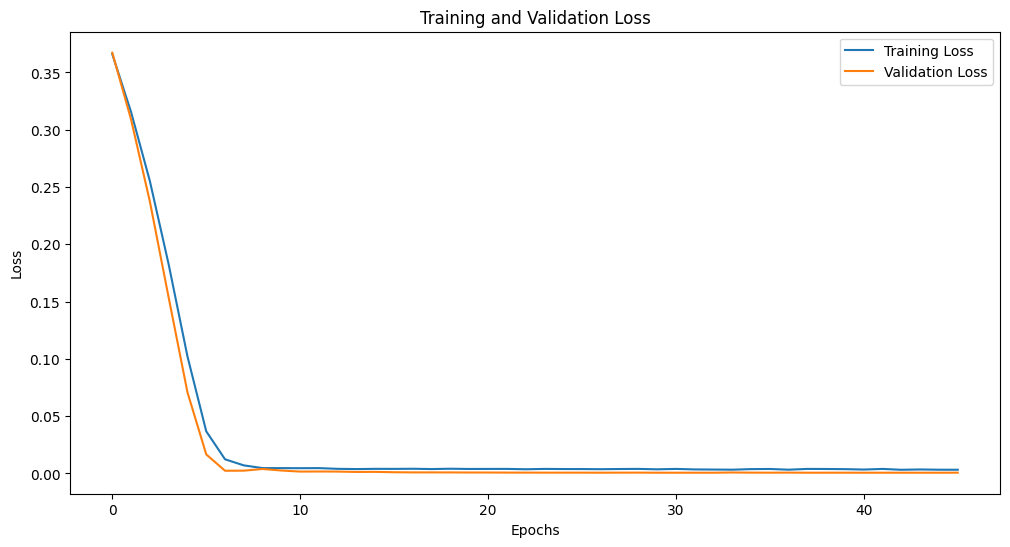

In [ ]:
# Entrenar modelo con los datos de entrenamiento y validación
model = build_model((window_size, X_train_seq.shape[2]))
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=50, verbose=0, validation_data=(X_val_seq, y_val_seq),
                    callbacks=[early_stopping])

# Gráfico de pérdida para entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Guardar el modelo entrenado en un archivo con joblib
model_path = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240530_trained_model_v8.pkl'
joblib.dump(model, model_path)

['/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240530_trained_model_v8.pkl']

In [ ]:
# Cargar el modelo entrenado desde el archivo
#model_path = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240529_trained_model_v8.pkl'
#model = joblib.load(model_path)

# Walk-Forward Validation solo con los datos de prueba
actuals = []
predictions = []
test_losses = []
step_size = 1

for i in range(len(X_test_seq)):
    X_test_wfv, y_test_wfv = X_test_seq[i:i+step_size], y_test_seq[i:i+step_size]

    # Hacer predicciones para el paso actual
    preds = model.predict(X_test_wfv).flatten()
    preds_rescaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
    y_test_rescaled = scaler_y.inverse_transform(y_test_wfv.reshape(-1, 1)).flatten()

    predictions.extend(preds_rescaled)
    actuals.extend(y_test_rescaled)

    # Evaluar el modelo sobre los datos de prueba actuales y almacenar la pérdida
    test_loss = mean_squared_error(y_test_rescaled, preds_rescaled)
    test_losses.append(test_loss)

    # Actualizar el modelo con nuevos datos
    h = model.fit(X_test_wfv, y_test_wfv, epochs=50, batch_size=5, verbose=0, validation_data=(X_test_wfv, y_test_wfv),
              callbacks=[early_stopping])

    print(f"Iteración N° {i}")

1/1 [==============================] - 1s 1s/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 0
1/1 [==============================] - 0s 21ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 1
1/1 [==============================] - 0s 23ms/step
Restoring model weights from the end of the best epoch: 15.
Epoch 45: early stopping
Iteración N° 2
1/1 [==============================] - 0s 24ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 3
1/1 [==============================] - 0s 27ms/step
Restoring model weights from the end of the best epoch: 3.
Epoch 33: early stopping
Iteración N° 4
1/1 [==============================] - 0s 22ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 5
1/1 [==============================] - 0s 27ms/step
Restoring model weights from the end of the

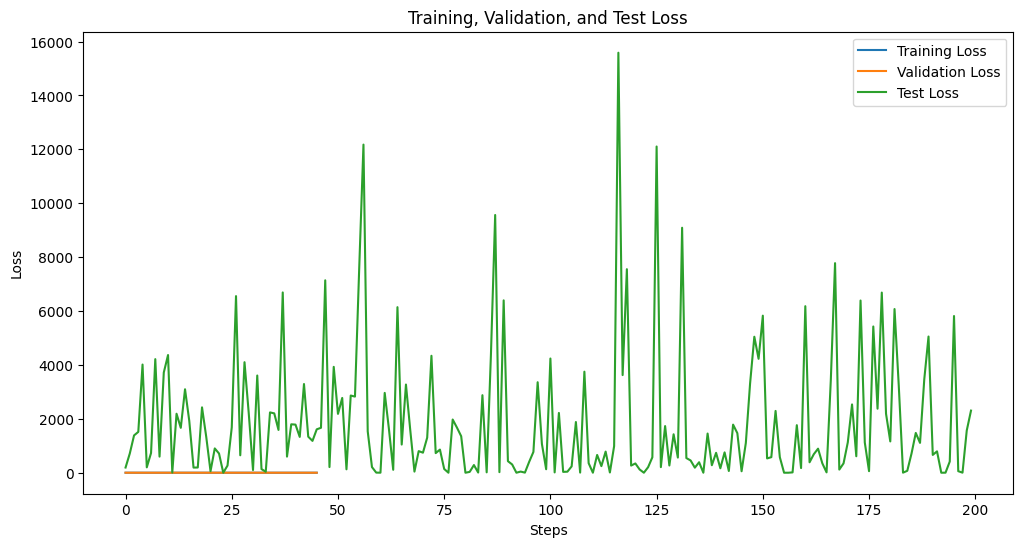

In [ ]:
# Gráfico de pérdida para entrenamiento, validación y prueba
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

In [ ]:
# Eliminar el primer valor del índice
y_test_index_modified = y_test.index[1:]  # Esto elimina el primer valor del índice
results_df1 = pd.DataFrame({'Actual': actuals, 'Predicted': predictions}, y_test_index_modified)
last_date = results_df1.index[-1]
next_date = last_date + timedelta(days=1)
extended_index = y_test_index_modified.tolist() + [next_date]

In [ ]:
# Predicción para el siguiente día después del último día disponible
last_sequence = X_test_seq[-window_size:].reshape(1, window_size, X_test_seq.shape[2])
next_step_prediction = model.predict(last_sequence).flatten()[0]
next_step_prediction_rescaled = scaler_y.inverse_transform(np.array([next_step_prediction]).reshape(-1, 1)).flatten()[0]
print("La predicción para el siguiente día es:", next_step_prediction_rescaled)
predictions.append(next_step_prediction_rescaled)  # Agregar predicción
actuals.append(actuals[-1])  # Repetir el último valor real para alinear con la predicción futura
results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions}, extended_index)
results_df

1/1 [==============================] - 0s 23ms/step
La predicción para el siguiente día es: 5272.295


Actual    Predicted
2023-08-15  4454.00  4440.129395
2023-08-16  4420.00  4393.272461
2023-08-17  4384.50  4347.291504
2023-08-18  4382.75  4343.818359
2023-08-21  4412.50  4349.138672
...             ...          ...
2024-05-24  5321.50  5329.043945
2024-05-28  5324.75  5323.258789
2024-05-29  5284.00  5323.599121
2024-05-30  5253.00  5301.016113
2024-05-31  5253.00  5272.294922

[201 rows x 2 columns]

In [ ]:
# Visualizar los resultados
fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'], mode='lines', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'], mode='lines', name='Predicted', line=dict(dash='dash', color='red')))

# Calcular métricas para WFV
wfv_mae = mean_absolute_error(results_df['Actual'].dropna(), results_df['Predicted'].dropna())
wfv_mse = mean_squared_error(results_df['Actual'].dropna(), results_df['Predicted'].dropna())
wfv_rmse = np.sqrt(wfv_mse)
wfv_errors = np.abs(results_df['Actual'].dropna() - results_df['Predicted'].dropna())
wfv_std_dev_ae = np.std(wfv_errors)
wfv_mape = np.mean(np.abs((results_df['Actual'].dropna() - results_df['Predicted'].dropna()) / results_df['Actual'].dropna())) * 100

fig.update_layout(
    title=f'Actual vs Predicted Prices (WFV)<br>Prediction for the next day: {next_step_prediction_rescaled:.2f}<br>RMSE: {wfv_rmse:.6f}<br>MAE: {wfv_mae:.6f}<br>SD of AE: {wfv_std_dev_ae:.6f}<br>MAPE: {wfv_mape:.6f}%',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

fig.show()

In [ ]:
# Crear una nueva columna 'DifferenceA' donde cada valor es 'Actual' - 'Actual anterior' de la fila anterior.
#results_df['DifferenceA'] = results_df['Actual'] - results_df['Actual'].shift(1)

# Crear una nueva columna 'DifferenceP' donde cada valor es 'Predicted' - 'Predicted anterior' de la fila anterior.
results_df['DifferenceP'] = results_df['Predicted']- results_df['Predicted'].shift(1)

# Crear la columna 'c1v-1' usando np.where
results_df['c1v-1'] = np.where(results_df['DifferenceP'] >= 0, 1, -1)


# Calculamos las diferencias entre el valor actual y el valor anterior de 'Actual'
results_df['Prev_Actual'] = results_df['Actual'].shift(1)
results_df['DifferenceA'] = results_df['Actual'] - results_df['Prev_Actual']

# Crear la columna 'Actual_SB' usando np.where
results_df['Actual_SB'] = np.where(results_df['DifferenceA'] >= 0, 1, -1)

# Definimos una función que evalúa las condiciones y calcula el valor de 'gan'
def calculate_gain(row):
    if row['c1v-1'] == 1:
        return row['DifferenceA']  # Si c1v-1 es 0, retorna la diferencia directamente.
    else:
        if row['Actual'] < row['Prev_Actual']:
            return -row['DifferenceA']  # Si c1v-1 es -1 y Actual es menor, retorno positivo de la diferencia.
        else:
            return -row['DifferenceA']  # Si c1v-1 es -1 y Actual es mayor, retorno negativo de la diferencia.

# Aplicamos la función para crear la columna 'G/P_P'
results_df['G/P_P'] = results_df.apply(calculate_gain, axis=1)

# Aplicamos la función para crear la columna 'G/P_D'
results_df['G/P_D'] = results_df['G/P_P'] * 5

# Eliminamos la columna auxiliar si no es necesaria
results_df.drop('Prev_Actual', axis=1, inplace=True)

# Crear la columna 'decision' basada en las condiciones especificadas
results_df['decision'] = np.where(
    ((results_df['c1v-1'] == 1) & (results_df['G/P_P'] >= 0)) |
    ((results_df['c1v-1'] == -1) & (results_df['G/P_P'] >= 0)),
    'Correcta',
    'Incorrecta'
)

# Mostrar las primeras filas del DataFrame para verificar los resultados
#print(results_df.head(5))

# Mostrar las ultimas filas del DataFrame para verificar los resultados
#print(results_df.tail(5))

# Calcular la suma total de la columna 'gan'
total_gain_P = results_df['G/P_P'].sum()
total_gain_D = results_df['G/P_D'].sum()

# Imprimir el resultado
print("La suma total de la columna 'G/P_P' es:", total_gain_P)
print("La suma total de la columna 'G/P_D' es:", total_gain_D)

results_df

La suma total de la columna 'G/P_P' es: 303.48046875
La suma total de la columna 'G/P_D' es: 1517.40234375


Actual    Predicted  DifferenceP  c1v-1  DifferenceA  Actual_SB  \
2023-08-15  4454.00  4440.129395          NaN     -1          NaN         -1   
2023-08-16  4420.00  4393.272461   -46.856934     -1       -34.00         -1   
2023-08-17  4384.50  4347.291504   -45.980957     -1       -35.50         -1   
2023-08-18  4382.75  4343.818359    -3.473145     -1        -1.75         -1   
2023-08-21  4412.50  4349.138672     5.320312      1        29.75          1   
...             ...          ...          ...    ...          ...        ...   
2024-05-24  5321.50  5329.043945   -32.467285     -1        36.25          1   
2024-05-28  5324.75  5323.258789    -5.785156     -1         3.25          1   
2024-05-29  5284.00  5323.599121     0.340332      1       -40.75         -1   
2024-05-30  5253.00  5301.016113   -22.583008     -1       -31.00         -1   
2024-05-31  5253.00  5272.294922   -28.721191     -1         0.00          1   

            G/P_P   G/P_D    decision  
2023-08-15    NaN     NaN  Incorrecta  
2023-08-16  34.00  170.00    Correcta  
2023-08-17  35.50  177.50    Correcta  
2023-08-18   1.75    8.75    Correcta  
2023-08-21  29.75  148.75    Correcta  
...           ...     ...         ...  
2024-05-24 -36.25 -181.25  Incorrecta  
2024-05-28  -3.25  -16.25  Incorrecta  
2024-05-29 -40.75 -203.75  Incorrecta  
2024-05-30  31.00  155.00    Correcta  
2024-05-31  -0.00   -0.00    Correcta  

[201 rows x 9 columns]

In [ ]:
def calculate_sharpe_ratio(returns, initial_capital, risk_free_rate=0.05):
    returns = returns / initial_capital
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

def calculate_sortino_ratio(returns, initial_capital, risk_free_rate=0.05):
    returns = returns / initial_capital
    excess_returns = returns - risk_free_rate / 252
    negative_returns = returns[returns < 0]
    downside_deviation = np.std(negative_returns)
    return np.mean(excess_returns) / downside_deviation * np.sqrt(252)

def calculate_maximum_drawdown(returns, initial_capital):
    cumulative_returns = np.cumsum(returns) + initial_capital
    rolling_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns / rolling_max - 1.0
    return drawdown.min()

def calculate_rate_of_return(returns, initial_capital):
    final_value = initial_capital + np.sum(returns)
    return (final_value - initial_capital) / initial_capital

def calculate_total_return(returns):
    return np.sum(returns)

In [ ]:
# Supongamos que results_df es tu DataFrame que contiene la columna 'G/P_D'
# Cargar el DataFrame (asegúrate de ajustar el path a tu archivo CSV)
# results_df = pd.read_csv('path_to_your_csv_file.csv')

# Definir el capital inicial
initial_capital = 2000

# Calcular retornos diarios a partir de la columna 'G/P_D'
returns = results_df['G/P_D'].dropna().values

# Calcular Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(returns, initial_capital)
print(f'Sharpe Ratio: {sharpe_ratio}')

# Calcular Sortino Ratio
sortino_ratio = calculate_sortino_ratio(returns, initial_capital)
print(f'Sortino Ratio: {sortino_ratio}')

# Calcular Maximum Drawdown
max_drawdown = calculate_maximum_drawdown(returns, initial_capital)
print(f'Maximum Drawdown: {max_drawdown}')

# Calcular Rate of Return
rate_of_return = calculate_rate_of_return(returns, initial_capital)
print(f'Rate of Return: {rate_of_return}')

# Calcular Total Return
total_return = calculate_total_return(returns)
print(f'Total Return: {total_return}')

Sharpe Ratio: 0.6271344782009048
Sortino Ratio: 0.9017960377433466
Maximum Drawdown: -0.6041803149397788
Rate of Return: 0.758701171875
Total Return: 1517.40234375


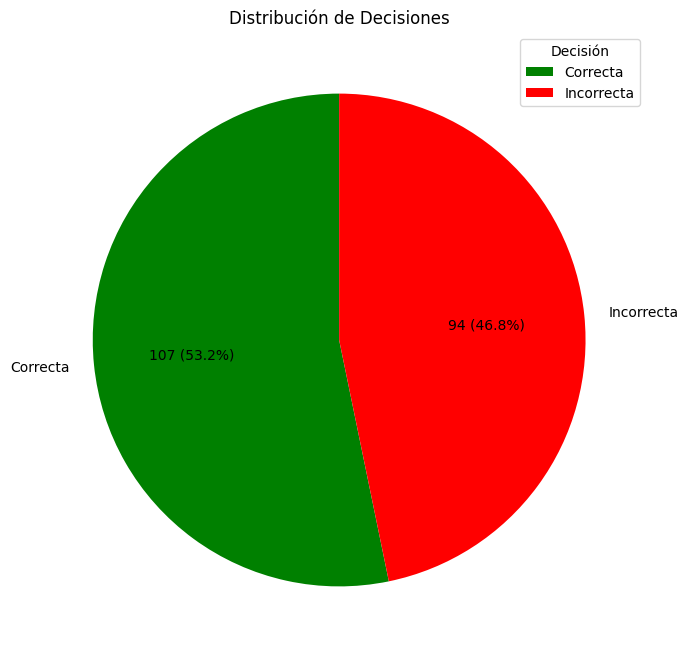

In [ ]:
#Cantidad de decisiones correctas

# Recuento de entradas por categoría en la columna 'decision'
decision_counts = results_df['decision'].value_counts()

# Función para formatear las etiquetas con valores absolutos y porcentajes
def absolute_and_percent(val):
    a = int(np.round(val/100.*decision_counts.sum()))
    return f"{a} ({val:.1f}%)"

# Graficar el gráfico de pastel
plt.figure(figsize=(8, 8))  # Ajustar tamaño del gráfico
plt.pie(decision_counts, labels=decision_counts.index, autopct=absolute_and_percent, startangle=90, colors=['green', 'red'])
plt.title('Distribución de Decisiones')

# Opcional: agregar una leyenda
plt.legend(decision_counts.index, title="Decisión", loc="best")

plt.show()


In [ ]:
# Agrupar por 'c1v-1' y contar las decisiones en cada grupo
grouped_decision_counts = results_df.groupby('decision')['c1v-1'].value_counts().unstack()

print(grouped_decision_counts)  # Ver los datos agrupados

c1v-1       -1   1
decision          
Correcta    41  66
Incorrecta  45  49


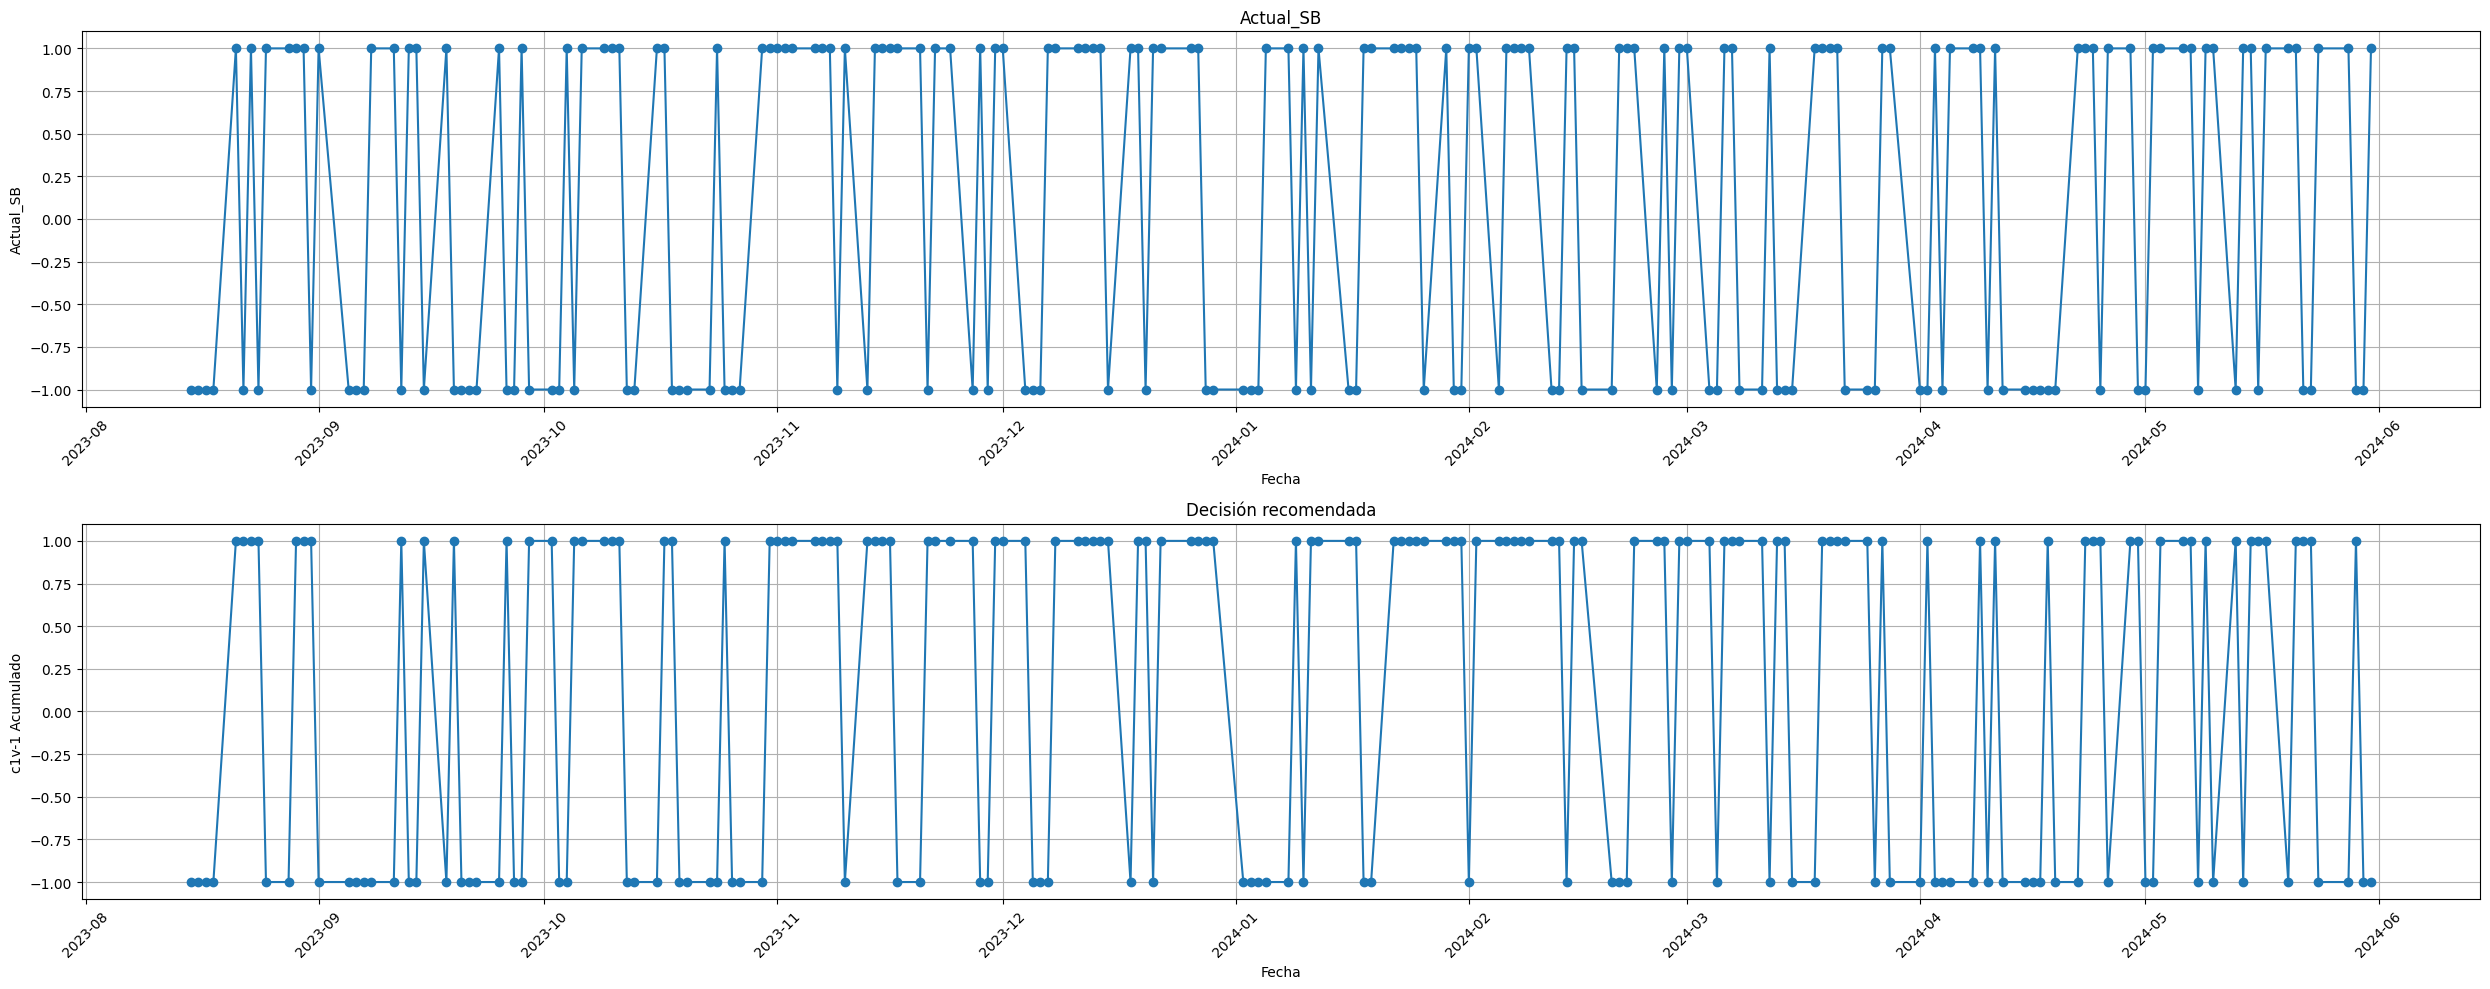

In [ ]:
# Crear una figura con tres subplots (3 filas, 1 columna)
fig, axes = plt.subplots(2, 1, figsize=(25, 10))

# Graficar el acumulado de 'Actual_SB' por fecha
axes[0].plot(results_df.index, results_df['Actual_SB'], marker='o', linestyle='-')
axes[0].set_title('Actual_SB')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Actual_SB')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Graficar el acumulado de 'c1v-1' por fecha
axes[1].plot(results_df.index, results_df['c1v-1'], marker='o', linestyle='-')
axes[1].set_title('Decisión recomendada')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('c1v-1 Acumulado')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Ajustar automáticamente los parámetros de la subtrama para dar espacio al diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

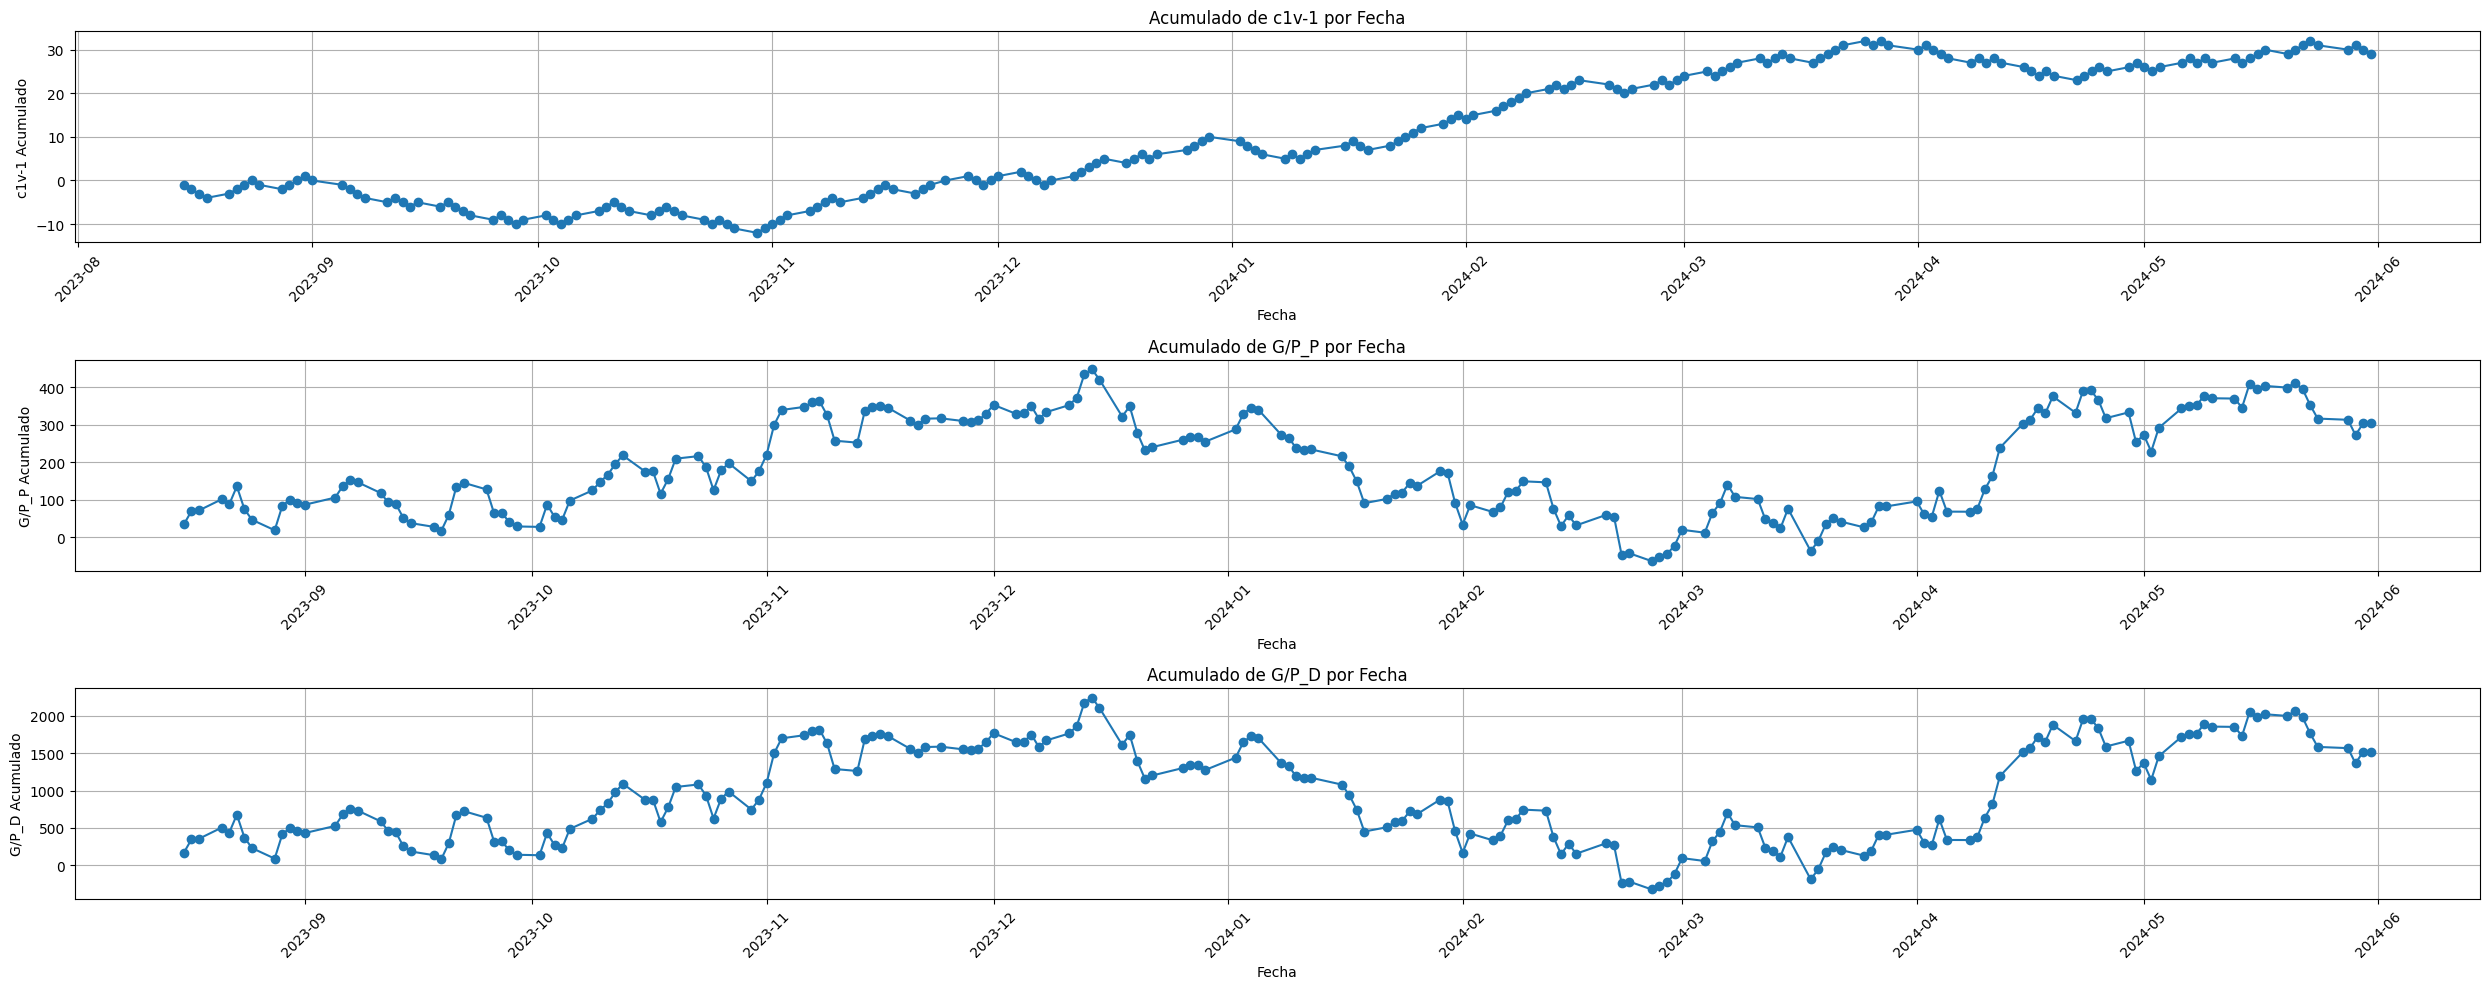

In [ ]:
# Calcular la suma acumulativa
results_df['c1v-1_acumulado'] = results_df['c1v-1'].cumsum()
results_df['G/P_P_acumulado'] = results_df['G/P_P'].cumsum()
results_df['G/P_D_acumulado'] = results_df['G/P_D'].cumsum()

# Crear una figura con tres subplots (3 filas, 1 columna)
fig, axes = plt.subplots(3, 1, figsize=(25, 10))

# Graficar el acumulado de 'G/P_P' por fecha
axes[0].plot(results_df.index, results_df['c1v-1_acumulado'], marker='o', linestyle='-')
axes[0].set_title('Acumulado de c1v-1 por Fecha')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('c1v-1 Acumulado')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Graficar el acumulado de 'G/P_P' por fecha
axes[1].plot(results_df.index, results_df['G/P_P_acumulado'], marker='o', linestyle='-')
axes[1].set_title('Acumulado de G/P_P por Fecha')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('G/P_P Acumulado')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Graficar el acumulado de 'G/P_D' por fecha
axes[2].plot(results_df.index, results_df['G/P_D_acumulado'], marker='o', linestyle='-')
axes[2].set_title('Acumulado de G/P_D por Fecha')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('G/P_D Acumulado')
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)

# Ajustar automáticamente los parámetros de la subtrama para dar espacio al diseño
plt.tight_layout()

# Mostrar la figura
plt.show()


In [ ]:
results_df.describe ()

Actual    Predicted  DifferenceP       c1v-1  DifferenceA  \
count   201.000000   201.000000   200.000000  201.000000   200.000000   
mean   4797.095324  4798.216797     4.160828    0.144279     3.995000   
std     354.796612   356.937897    38.320129    0.992008    36.303487   
min    4137.750000  4132.226074  -127.043457   -1.000000   -80.500000   
25%    4461.750000  4452.002930   -16.364746   -1.000000   -17.062500   
50%    4815.500000  4813.844238     3.559570    1.000000     3.375000   
75%    5107.500000  5107.874512    23.506104    1.000000    27.250000   
max    5345.250000  5361.511230   133.496582    1.000000   113.080078   

        Actual_SB       G/P_P       G/P_D  c1v-1_acumulado  G/P_P_acumulado  \
count  201.000000  200.000000  200.000000       201.000000       200.000000   
mean     0.104478    1.517402    7.587012        10.213930       189.153906   
std      0.997010   36.492044  182.460221        14.491342       130.327201   
min     -1.000000 -113.080078 -565.400391       -12.000000       -64.269531   
25%     -1.000000  -18.062500  -90.312500        -3.000000        76.125488   
50%      1.000000    1.375000    6.875000         7.000000       164.210449   
75%      1.000000   26.062500  130.312500        26.000000       316.262939   
max      1.000000   85.750000  428.750000        32.000000       448.190430   

       G/P_D_acumulado  
count       200.000000  
mean        945.769531  
std         651.636007  
min        -321.347656  
25%         380.627441  
50%         821.052246  
75%        1581.314697  
max        2240.952148

In [ ]:
csv_path = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240530_salida_v8.csv'  # Define la ruta en Google Drive.

results_df.to_csv(csv_path, index=True)  # Guarda el DataFrame como CSV en la ruta especificada.

In [ ]:
df = results_df

# Calculando los retornos logarítmicos de las predicciones
df['log_returns'] = np.log(df['Predicted'] / df['Predicted'].shift(1))

# Eliminar cualquier NaN que pueda haber surgido del cálculo de los retornos
df.dropna(inplace=True)

# Calcular la desviación estándar de los retornos logarítmicos
volatilidad = df['log_returns'].std()

# La volatilidad anualizada se puede calcular asumiendo un número de periodos por año (por ejemplo, días de operación en el mercado)
dias_operacion = 252  # típicamente los días de operación de un mercado de valores
volatilidad_anualizada = volatilidad * np.sqrt(dias_operacion)

print(f"Volatilidad diaria: {volatilidad}")
print(f"Volatilidad anualizada: {volatilidad_anualizada}")


Volatilidad diaria: 0.008245095610618591
Volatilidad anualizada: 0.13088683512988225


In [ ]:
# Define el número de días que quieres extraer
d = 6

# Extraer las últimas 'd' filas del DataFrame, incluyendo el índice de fecha
test_data = df[['Actual', 'Predicted']].tail(d)
test_data

Actual    Predicted
2024-05-23  5285.25  5361.511230
2024-05-24  5321.50  5329.043945
2024-05-28  5324.75  5323.258789
2024-05-29  5284.00  5323.599121
2024-05-30  5253.00  5301.016113
2024-05-31  5253.00  5272.294922

In [ ]:
sigma = volatilidad  # Ajusta este valor según tus datos o análisis
N = 5000  # Número de simulaciones
T = d  # Simular 5 días adelante

# Función para realizar simulación de Montecarlo
def montecarlo_simulation(start_price, sigma, N, T):
    prices = np.zeros((N, T+1))
    prices[:, 0] = start_price
    for t in range(1, T+1):
        z = np.random.standard_normal(N)
        prices[:, t] = prices[:, t-1] * np.exp(-0.5 * sigma**2 + sigma * z)
    return prices

# Crear una columna en test_data para almacenar los resultados de Monte Carlo
test_data['MonteCarloResults'] = None
test_data['MeanMC'] = None

for index, row in test_data.iterrows():
    mc_results = montecarlo_simulation(row['Predicted'], sigma, N, T)
    test_data.at[index, 'MonteCarloResults'] = mc_results[:, -1]  # Guardar solo el último día de cada simulación
    test_data.at[index, 'MeanMC'] = np.mean(mc_results[:, -1])

print(test_data)

             Actual    Predicted  \
2024-05-23  5285.25  5361.511230   
2024-05-24  5321.50  5329.043945   
2024-05-28  5324.75  5323.258789   
2024-05-29  5284.00  5323.599121   
2024-05-30  5253.00  5301.016113   
2024-05-31  5253.00  5272.294922   

                                            MonteCarloResults       MeanMC  
2024-05-23  [5362.64619192695, 5294.090904680056, 5310.100...  5361.975911  
2024-05-24  [5453.856274335134, 5485.78014888898, 5268.126...  5326.479468  
2024-05-28  [5316.830181028362, 5406.799087708144, 5464.66...  5321.853349  
2024-05-29  [5286.7492481602285, 5202.945946754155, 5187.9...  5322.662198  
2024-05-30  [5308.263662168035, 5333.020057738477, 5397.35...  5300.859639  
2024-05-31  [5336.92401921901, 5162.0198938166595, 5098.94...  5272.515146  


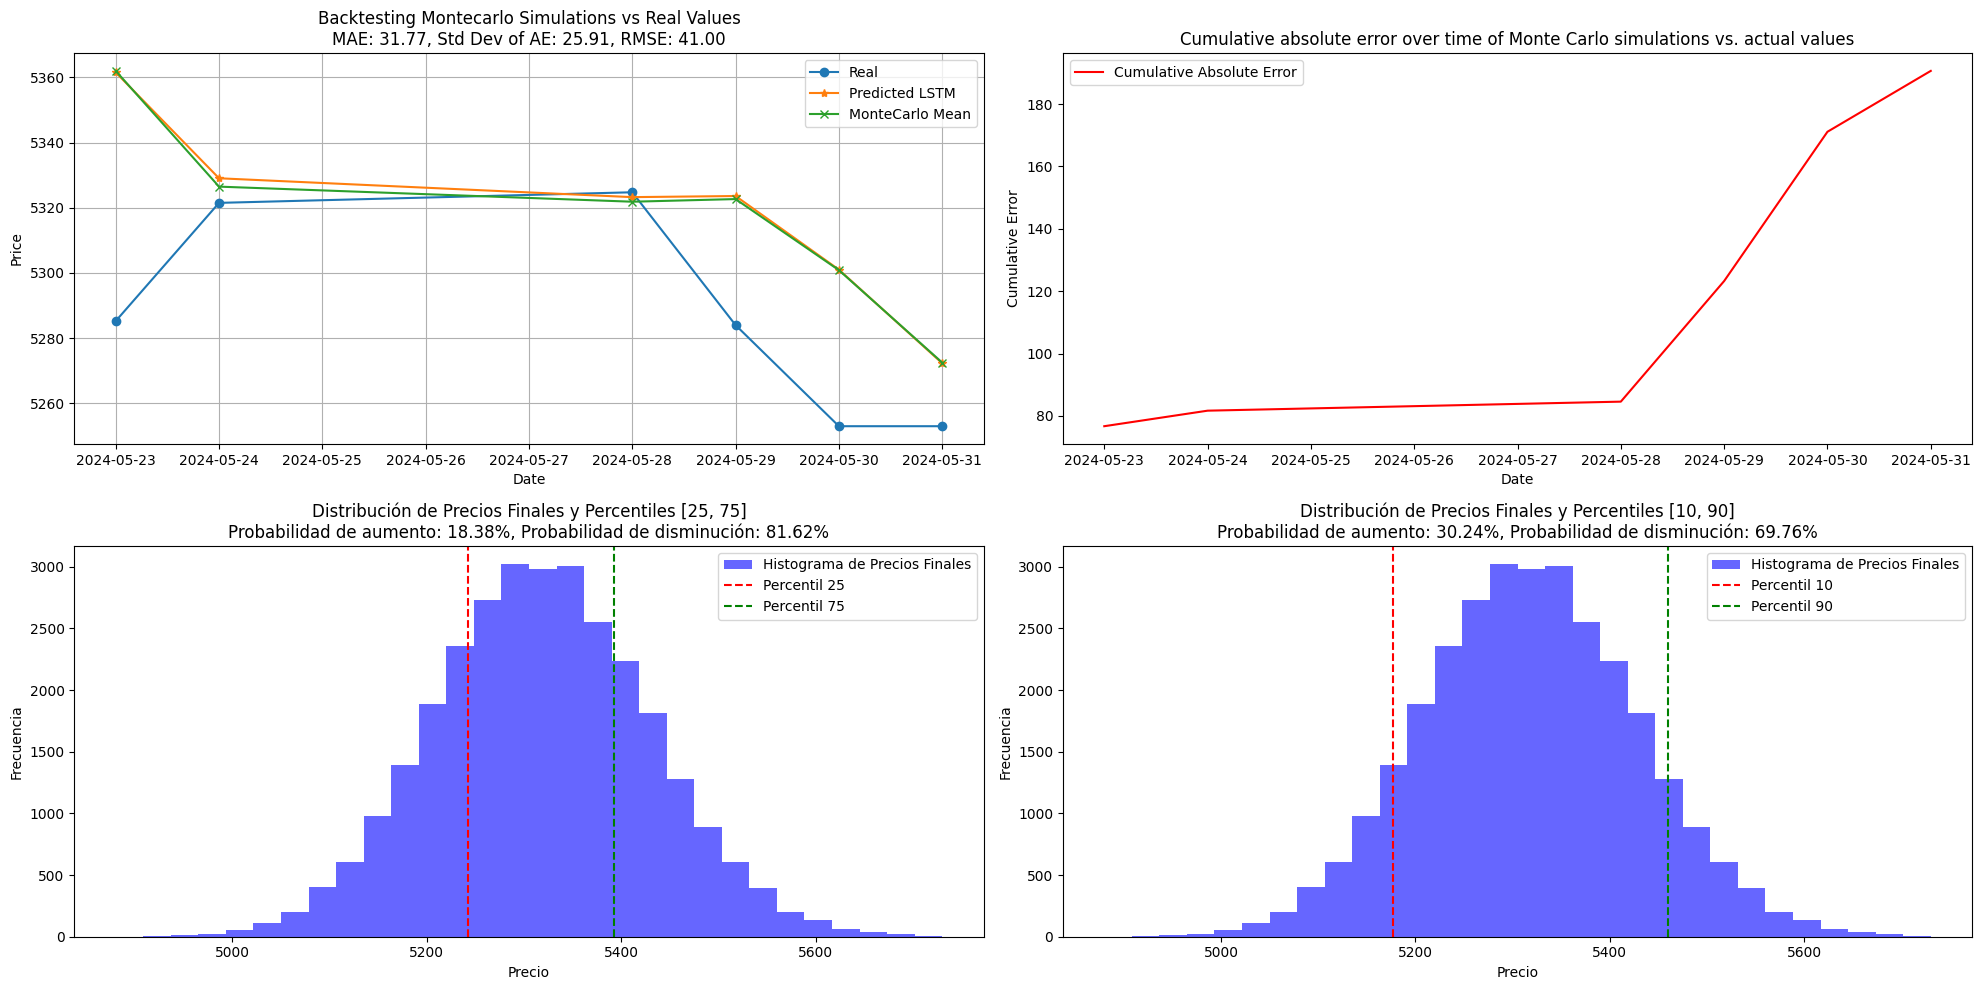

In [ ]:
# Calculando errores
mae = mean_absolute_error(test_data['Actual'], test_data['MeanMC'])
mse = np.sqrt(mean_squared_error(test_data['Actual'], test_data['MeanMC']))

# Calculando la desviación estándar de los errores absolutos
errors = np.abs(test_data['Actual'] - test_data['MeanMC'])
std_dev = np.std(errors)

# Configuración de tres gráficos lado a lado
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Visualización de resultados en el primer gráfico
ax1.plot(test_data.index, test_data['Actual'], label='Real', marker='o')
ax1.plot(test_data.index, test_data['Predicted'], label='Predicted LSTM', marker='*')
ax1.plot(test_data.index, test_data['MeanMC'], label='MonteCarlo Mean', marker='x')
ax1.legend()
ax1.set_title('Backtesting Montecarlo Simulations vs Real Values\n' +
              f"MAE: {mae:.2f}, Std Dev of AE: {std_dev:.2f}, RMSE: {mse:.2f}")
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True)

# Visualización de resultados en el segundo gráfico
#cumulative_absolute_error = np.cumsum(np.abs(test_data['Actual'] - test_data['Predicted']))
cumulative_absolute_error = np.cumsum(np.abs(test_data['Actual'] - test_data['MeanMC']))
ax2.plot(test_data.index, cumulative_absolute_error, label='Cumulative Absolute Error', color='red')
ax2.set_title('Cumulative absolute error over time of Monte Carlo simulations vs. actual values')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Error')
ax2.legend()

# Cálculo y visualización de percentiles [25, 75] en el tercer gráfico
prices = np.concatenate(test_data['MonteCarloResults'].values)
final_prices = prices
lower_bound, upper_bound = np.percentile(final_prices, [25, 75])
filtered_prices = final_prices[(final_prices >= lower_bound) & (final_prices <= upper_bound)]
prob_increase_filtered = np.mean(filtered_prices > test_data['Predicted'].iloc[0])
prob_decrease_filtered = np.mean(filtered_prices < test_data['Predicted'].iloc[0])

ax3.hist(final_prices, bins=30, alpha=0.6, color='blue', label='Histograma de Precios Finales')
ax3.axvline(x=lower_bound, color='red', linestyle='dashed', linewidth=1.5, label='Percentil 25')
ax3.axvline(x=upper_bound, color='green', linestyle='dashed', linewidth=1.5, label='Percentil 75')
ax3.set_title('Distribución de Precios Finales y Percentiles [25, 75]\n' +
              f"Probabilidad de aumento: {prob_increase_filtered * 100:.2f}%, " +
              f"Probabilidad de disminución: {prob_decrease_filtered * 100:.2f}%")
ax3.set_xlabel('Precio')
ax3.set_ylabel('Frecuencia')
ax3.legend()

# Cálculo y visualización de percentiles [10, 90] en el cuarto gráfico
lower_bound_wide, upper_bound_wide = np.percentile(final_prices, [10, 90])
filtered_prices_wide = final_prices[(final_prices >= lower_bound_wide) & (final_prices <= upper_bound_wide)]
prob_increase_wide = np.mean(filtered_prices_wide > test_data['Predicted'].iloc[0])
prob_decrease_wide = np.mean(filtered_prices_wide < test_data['Predicted'].iloc[0])

ax4.hist(final_prices, bins=30, alpha=0.6, color='blue', label='Histograma de Precios Finales')
ax4.axvline(x=lower_bound_wide, color='red', linestyle='dashed', linewidth=1.5, label='Percentil 10')
ax4.axvline(x=upper_bound_wide, color='green', linestyle='dashed', linewidth=1.5, label='Percentil 90')
ax4.set_title('Distribución de Precios Finales y Percentiles [10, 90]\n' +
              f"Probabilidad de aumento: {prob_increase_wide * 100:.2f}%, " +
              f"Probabilidad de disminución: {prob_decrease_wide * 100:.2f}%")
ax4.set_xlabel('Precio')
ax4.set_ylabel('Frecuencia')
ax4.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()